### RAG Fusion

This is similar to multi-query except here we apply clever ranking step to multi-query

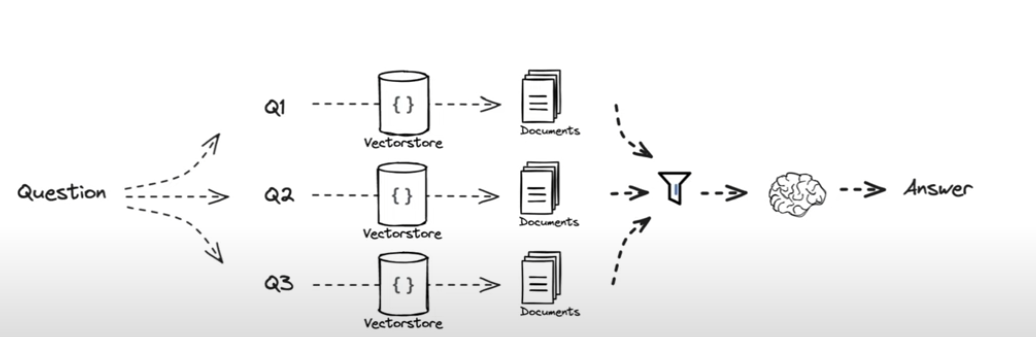

In [1]:

from langchain_google_genai import ChatGoogleGenerativeAI

# To configure model parameters use the `generation_config` parameter.
# eg. generation_config = {"temperature": 0.7, "topP": 0.8, "topK": 40}
# If you only want to set a custom temperature for the model use the
# "temperature" parameter directly.

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest", temperature=0.7, )

d:\VS Code\python\dsa_projects\RAG\notes_rag\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
from langchain.prompts import ChatPromptTemplate

# RAG-Fusion: Related
template = """You are a helpful assistant that generates multiple search queries based on a single input query. Make sure to generate only queries and no extra information. \n
Generate multiple search queries related to: {question} \n
Output (4 queries):"""
prompt_rag_fusion = ChatPromptTemplate.from_template(template)

In [12]:
from langchain_core.output_parsers import StrOutputParser

generate_queries = (
    prompt_rag_fusion 
    | llm
    | StrOutputParser() 
    | (lambda x: x.split("\n"))
)

In [13]:
generate_queries.invoke("What is Kubernetes?")

['- Kubernetes definition',
 '- What is Kubernetes used for',
 '- How does Kubernetes work',
 '- Kubernetes benefits ',
 '']

In [5]:
from langchain_chroma import Chroma
from langchain_community.embeddings.sentence_transformer import SentenceTransformerEmbeddings

persist_dir = "chromadb"
embedding_function = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")

newdb = Chroma(persist_directory=persist_dir, embedding_function=embedding_function)
retriever = newdb.as_retriever()

d:\VS Code\python\dsa_projects\RAG\notes_rag\venv\Lib\site-packages\langchain_core\_api\deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  warn_deprecated(


In [7]:
question = "What is Kubernetes?"

In [14]:
from langchain.load import dumps, loads

def reciprocal_rank_fusion(results: list[list], k=60):
    """ Reciprocal_rank_fusion that takes multiple lists of ranked documents 
        and an optional parameter k used in the RRF formula """
    
    # Initialize a dictionary to hold fused scores for each unique document
    fused_scores = {}

    # Iterate through each list of ranked documents
    for docs in results:
        # Iterate through each document in the list, with its rank (position in the list)
        for rank, doc in enumerate(docs):
            # Convert the document to a string format to use as a key (assumes documents can be serialized to JSON)
            doc_str = dumps(doc)
            # If the document is not yet in the fused_scores dictionary, add it with an initial score of 0
            if doc_str not in fused_scores:
                fused_scores[doc_str] = 0
            # Retrieve the current score of the document, if any
            previous_score = fused_scores[doc_str]
            # Update the score of the document using the RRF formula: 1 / (rank + k)
            fused_scores[doc_str] += 1 / (rank + k)

    # Sort the documents based on their fused scores in descending order to get the final reranked results
    reranked_results = [
        (loads(doc), score)
        for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    ]

    # Return the reranked results as a list of tuples, each containing the document and its fused score
    return reranked_results

retrieval_chain_rag_fusion = generate_queries | retriever.map() | reciprocal_rank_fusion
docs = retrieval_chain_rag_fusion.invoke({"question": question})
len(docs)

15

In [19]:
from langchain_core.runnables import RunnablePassthrough
from operator import itemgetter

# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    {"context": retrieval_chain_rag_fusion, 
     "question": itemgetter("question")} 
    | prompt
    | llm
    | StrOutputParser()
)

response = final_rag_chain.invoke({"question":"What are volumes in Kubernetes?"})

In [20]:
print(response)

The provided text doesn't explicitly define what volumes are in Kubernetes, but it does provide several examples and uses of volumes. Based on these examples, we can infer that volumes are:

* **Storage mechanisms** that can be attached to pods. They provide a way for pods to access persistent data or files.
* **Mountable** within containers, allowing them to read and write data from the volume.
* **Used for various purposes:**
    * **Persistent storage:**  For data that needs to persist beyond the lifetime of a pod.
    * **Sharing data between containers:**  Allowing different containers in a pod to access the same data.
    * **Passing sensitive information:**  Such as passwords, through secret volumes.
    * **Pre-populating data:**  In cases like NFS volumes.

The text also mentions different types of volumes like `emptyDir`, `subpath volume`, and `secret volume`, further emphasizing their role as storage mechanisms. 

